In [1]:
''''COMPARE LARIAC, NEARMAP, AND ASSESSOR DATA AT LANDBASE'S AIN LVL

LANDBASE: 2016, PARCEL GEOM 
LARIAC: 2020, CALC. GROSS BLFG FOOTPRINT AREA (PER AIN, ALL STRUCTURES )
NEARMAP: 2023, CALC. GROSS BLFG FOOTPRINT AREA (PER AIN, ALL STRUCTURES )
ASSESSOR: 2016, SET AIN, SET SQFTMAIN (PER AIN, ALL STRUCTURES )

DIFF: LARIAC - ASSESSOR , BFP AREA - LVG AREA
DIFF: NEARMAP - ASSESSOR, BFP AREA - LVG AREA
'''

"'COMPARE LARIAC, NEARMAP, AND ASSESSOR DATA AT LANDBASE'S AIN LVL\n\nLANDBASE: 2016, PARCEL GEOM \nLARIAC: 2020, CALC. GROSS BLFG FOOTPRINT AREA (PER AIN, ALL STRUCTURES )\nNEARMAP: 2023, CALC. GROSS BLFG FOOTPRINT AREA (PER AIN, ALL STRUCTURES )\nASSESSOR: 2016, SET AIN, SET SQFTMAIN (PER AIN, ALL STRUCTURES )\n\nDIFF: LARIAC - ASSESSOR , BFP AREA - LVG AREA\nDIFF: NEARMAP - ASSESSOR, BFP AREA - LVG AREA\n"

In [6]:
import geopandas as gpd
import os

os.chdir('../..')
nearmap_tile = "/Users/adamswietek/Downloads/USC_Nearmap_Sample_Data/IMAGERY_SAMPLE_EPSG3857_Date20251005/Tiles.shp"
nearmap_building = '/Users/adamswietek/Downloads/USC_Nearmap_Sample_Data/AI_SAMPLE/ai_features_None_Building.gpkg'
nearmap_building = gpd.read_file(nearmap_building)
nearmap_tile = gpd.read_file(nearmap_tile)


In [7]:
'''load data by year'''
from src.geoadmin import load_laraic, get_landbase_bymask, load_assessor_parcels_bygeom

LANDBASE_YR = 2016
ASSESSOR_YR = 2016
LARIAC_YR = 2020

def load_data_by_year(neighborhood, 
                      lb_yr, apd_yr, lar_yr, source = 'lariac'):
    
    landbase_parcels = get_landbase_bymask(neighborhood, lb_yr)

    polygon_geometry = neighborhood.to_crs(4326).iloc[0].geometry
    assessor_data = load_assessor_parcels_bygeom(polygon_geometry)
    assessor_data = assessor_data.loc[assessor_data.RollYear == apd_yr]
    assessor_data = assessor_data.to_crs(landbase_parcels.crs)

    if source == 'lariac':
        lariac_structures = load_laraic(neighborhood, lar_yr)
        lariac_structures = lariac_structures.to_crs(landbase_parcels.crs)

    return landbase_parcels, assessor_data, lariac_structures

landbase, assessor, lariac = load_data_by_year(nearmap_tile.dissolve(), 
                                               lb_yr = LANDBASE_YR, 
                                               apd_yr = ASSESSOR_YR, 
                                               lar_yr = LARIAC_YR)

landbase2, assessor2, lariac2 = load_data_by_year(nearmap_tile.dissolve(), 
                                               lb_yr = 2016, 
                                               apd_yr = 2020, 
                                               lar_yr = 2014)

ERROR 1: PROJ: internal_proj_identify: /Users/adamswietek/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_identify: /Users/adamswietek/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_identify: /Users/adamswietek/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
ERROR 1: PROJ: internal_proj_identify: /Users/adamswietek/opt/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.
/opt/homebrew/Caskroom/miniforge/base/envs/samgeo/lib/python3.12/site-packages/pyogrio/core.py:280: UserWarning: Measured (M) geometry types are not supported. 

In [8]:
print(landbase.crs, assessor.crs, lariac.crs, nearmap_building.crs)

EPSG:2229 EPSG:2229 EPSG:2229 EPSG:4326


In [9]:
nearmap_building.to_crs(landbase.crs, inplace=True)

count    5321.000000
mean        1.385265
std         3.603433
min       -21.321177
25%        -0.712260
50%         1.085000
75%         3.354761
max        25.880972
dtype: float64


<Axes: >

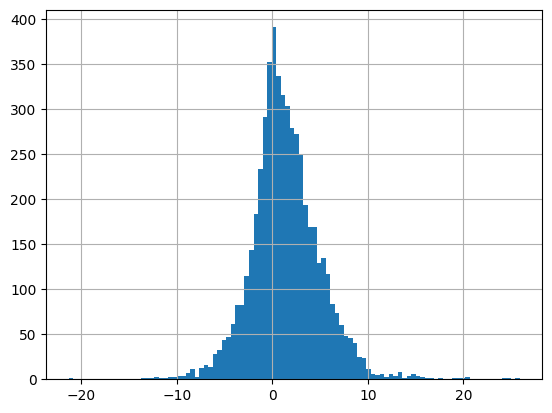

In [10]:
' calculated area vs area col is different. why?'
print((nearmap_building.area - nearmap_building.areaSqft).describe())#.hist(bins = 100)
(nearmap_building.area - nearmap_building.areaSqft).hist(bins = 100)

# (nearmap_building.area - nearmap_building.clippedAreaSqft).hist(bins = 100)

count    6.107000e+03
mean    -7.834790e-09
std      4.385217e-07
min     -2.692366e-06
25%     -2.472867e-07
50%     -1.251772e-08
75%      2.229658e-07
max      3.229070e-06
dtype: float64


<Axes: >

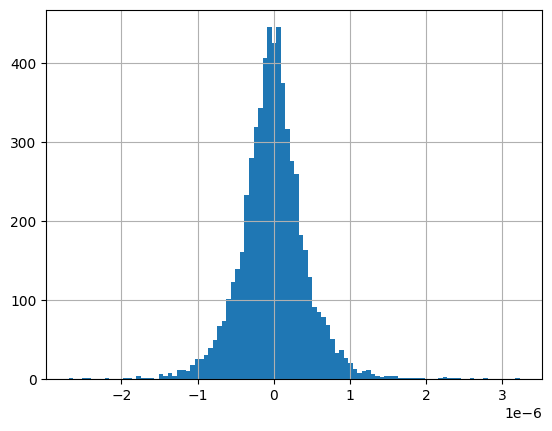

In [11]:
''' difference betwen lariac area col and calculated area is much smaller than nearmap's?'''
print((lariac.AREA - lariac.area).describe())
(lariac.AREA - lariac.area).hist(bins = 100)


In [49]:
nearmap_building['geomarea'] = nearmap_building.area
nm = nearmap_building[['id','areaSqft','clippedAreaSqft','geomarea','geometry']].copy()

lb = landbase[['ASSETID', 'geometry']].copy()

asr = assessor[assessor['PropertyType'] == "SFR"].copy()
asr2 = assessor2[assessor2['PropertyType'] == "SFR"].copy()

lar = lariac.dropna(subset=['HEIGHT'])[['BLD_ID','AREA', 'geometry']].copy()

In [50]:
print(lb.shape, asr.shape, lar.shape, nm.shape)

(4303, 2) (1251, 52) (6090, 3) (5321, 5)


In [157]:
'''merge landbase and assessor'''
joined = gpd.sjoin(lb, asr, how='inner', predicate='intersects')
joined2 = gpd.sjoin(lb, asr2, how='inner', predicate='intersects')

OVERLAP_THRESHOLD = 0.5  # reject if < 80% of building area is inside parcel

''' add lariac data to joined, use centroid to match structure to parcel'''
lar['lar_geometry'] = lar.geometry
lar_centroids = lar.copy()
lar_centroids.geometry = lar_centroids.geometry.centroid
joined_lar = gpd.sjoin(joined.drop(columns=['index_right']), lar_centroids, how='left', predicate='intersects')
# keep only buildings matched to exactly one parcel
lar_counts = joined_lar.groupby('BLD_ID').size()
joined_lar = joined_lar[joined_lar['BLD_ID'].isin(lar_counts[lar_counts == 1].index)]
# reject buildings with too much area outside the parcel
joined_lar['_overlap'] = (
    joined_lar['lar_geometry'].intersection(joined_lar['geometry']).area 
    / joined_lar['lar_geometry'].area
)
n_before = len(joined_lar)
joined_lar = joined_lar[joined_lar['_overlap'] >= OVERLAP_THRESHOLD]
print(f"LARIAC: {n_before} centroid-unique -> {len(joined_lar)} after overlap >= {OVERLAP_THRESHOLD}")

''' add nearmaps data to joined, use centroid to match structure to parcel'''
nm['nm_geometry'] = nm.geometry
nm_centroids = nm.copy()
nm_centroids.geometry = nm_centroids.geometry.centroid
joined_nm = gpd.sjoin(joined.drop(columns=['index_right']), nm_centroids, how='left', predicate='intersects')
# keep only buildings matched to exactly one parcel
nm_counts = joined_nm.groupby('index_right').size()
joined_nm = joined_nm[joined_nm['index_right'].isin(nm_counts[nm_counts == 1].index)]
# reject buildings with too much area outside the parcel
joined_nm['_overlap'] = (
    joined_nm['nm_geometry'].intersection(joined_nm['geometry']).area
    / joined_nm['nm_geometry'].area
)
n_before_nm = len(joined_nm)
joined_nm = joined_nm[joined_nm['_overlap'] >= OVERLAP_THRESHOLD].reset_index(drop=True)
print(f"Nearmap: {n_before_nm} centroid-unique -> {len(joined_nm)} after overlap >= {OVERLAP_THRESHOLD}")

LARIAC: 2166 centroid-unique -> 2162 after overlap >= 0.5
Nearmap: 1929 centroid-unique -> 1857 after overlap >= 0.5


In [158]:
results = {
    'assessor_size': joined.groupby('AIN').size(),
    # 'lariac_size': joined_lar.groupby('AIN').size(),
    # 'nearmap_size': joined_nm.groupby('AIN').size(),
    'lariac_area_2020': joined_lar.groupby('AIN')['AREA'].sum(),
    'nearmap_area_2023': joined_nm.groupby('AIN')['areaSqft'].sum(),
    'nearmap_geomarea_2023': joined_nm.groupby('AIN')['geomarea'].sum(),
    'assessor_area_2016': joined.groupby('AIN')['SQFTmain'].sum(),
    'assessor_area_2020': joined2.groupby('AIN')['SQFTmain'].sum(),
    #add geoms
    'lariac_geom_2020': joined_lar.groupby('AIN')['lar_geometry'].apply(lambda x: x.unary_union),
    'nearmap_geom_2023': joined_nm.groupby('AIN')['nm_geometry'].apply(lambda x: x.unary_union),
    'landbase_geom_2016': joined.groupby('AIN')['geometry'].apply(lambda x: x.unary_union)
}

/var/folders/7b/rl6lkdns1dbfv_n3wwwmq8580000gn/T/ipykernel_54157/4172771238.py:11: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  'lariac_geom_2020': joined_lar.groupby('AIN')['lar_geometry'].apply(lambda x: x.unary_union),
/var/folders/7b/rl6lkdns1dbfv_n3wwwmq8580000gn/T/ipykernel_54157/4172771238.py:12: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  'nearmap_geom_2023': joined_nm.groupby('AIN')['nm_geometry'].apply(lambda x: x.unary_union),
/var/folders/7b/rl6lkdns1dbfv_n3wwwmq8580000gn/T/ipykernel_54157/4172771238.py:13: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  'landbase_geom_2016': joined.groupby('AIN')['geometry'].apply(lambda x: x.unary_union)


In [159]:
import geopandas as gpd

df = gpd.GeoDataFrame(results, geometry='landbase_geom_2016')

In [160]:
'''--- SUMMARY STATS ---'''
area_cols = ['lariac_area_2020', 'nearmap_geomarea_2023','nearmap_area_2023', 'assessor_area_2016', 'assessor_area_2020']

print(f"df shape: {df.shape}")
print(f"\nZero / NaN counts:")
for c in area_cols:
    print(f"  {c:25s}  zero={int((df[c] == 0).sum()):4d}   NaN={int(df[c].isna().sum()):4d}")

print("\n--- Area distributions (sqft) ---")
df[area_cols].describe().round(1)

df shape: (1254, 9)

Zero / NaN counts:
  lariac_area_2020           zero=   0   NaN=   9
  nearmap_geomarea_2023      zero=   0   NaN= 121
  nearmap_area_2023          zero=   0   NaN= 121
  assessor_area_2016         zero=   2   NaN=   3
  assessor_area_2020         zero=   1   NaN=  49

--- Area distributions (sqft) ---


,lariac_area_2020,nearmap_geomarea_2023,nearmap_area_2023,assessor_area_2016,assessor_area_2020
count,1245.0,1133.0,1133.0,1251.0,1205.0
mean,2215.5,2340.7,2338.5,1340.4,1351.8
std,582.6,856.7,856.2,378.6,386.9
min,372.6,47.4,46.0,0.0,0.0
25%,1872.6,1905.7,1904.0,1108.0,1113.0
50%,2221.2,2274.0,2272.0,1284.0,1288.0
75%,2565.5,2706.7,2700.0,1486.0,1496.0
max,4665.5,6245.9,6233.0,3780.0,3780.0


In [161]:
'''filter to parcels with positive area in all sources for clean comparisons'''
import numpy as np

mask = (
    (df['lariac_area_2020'] > 0) & 
    (df['nearmap_area_2023'] > 0) & 
    (df['nearmap_geomarea_2023'] > 0) &
    (df['assessor_area_2016'] > 0) & 
    (df['assessor_area_2020'] > 0)
)
dfc = df[mask].copy()
print(f"Parcels with all areas > 0: {len(dfc)} / {len(df)}")

# absolute differences
dfc['diff_lar20_asr16'] = dfc['lariac_area_2020'] - dfc['assessor_area_2016']
dfc['diff_lar20_asr20'] = dfc['lariac_area_2020'] - dfc['assessor_area_2020']
dfc['diff_nm23_asr16']  = dfc['nearmap_area_2023'] - dfc['assessor_area_2016']
dfc['diff_nm23_asr20']  = dfc['nearmap_area_2023'] - dfc['assessor_area_2020']
dfc['diff_nm23g_asr16'] = dfc['nearmap_geomarea_2023'] - dfc['assessor_area_2016']
dfc['diff_nm23g_asr20'] = dfc['nearmap_geomarea_2023'] - dfc['assessor_area_2020']
dfc['diff_nm23_lar20']  = dfc['nearmap_area_2023'] - dfc['lariac_area_2020']
dfc['diff_asr20_asr16'] = dfc['assessor_area_2020'] - dfc['assessor_area_2016']

# percentage differences
dfc['pct_diff_lar20_asr16'] = (dfc['diff_lar20_asr16'] / dfc['assessor_area_2016']) * 100
dfc['pct_diff_lar20_asr20'] = (dfc['diff_lar20_asr20'] / dfc['assessor_area_2020']) * 100
dfc['pct_diff_nm23_asr16']  = (dfc['diff_nm23_asr16']  / dfc['assessor_area_2016']) * 100
dfc['pct_diff_nm23_asr20']  = (dfc['diff_nm23_asr20']  / dfc['assessor_area_2020']) * 100
dfc['pct_diff_nm23g_asr16'] = (dfc['diff_nm23g_asr16'] / dfc['assessor_area_2016']) * 100
dfc['pct_diff_nm23g_asr20'] = (dfc['diff_nm23g_asr20'] / dfc['assessor_area_2020']) * 100
dfc['pct_diff_nm23_lar20']  = (dfc['diff_nm23_lar20']  / dfc['lariac_area_2020']) * 100
dfc['pct_diff_asr20_asr16'] = (dfc['diff_asr20_asr16'] / dfc['assessor_area_2016']) * 100

print("\n--- Absolute Differences (sqft) ---")
diff_cols = ['diff_lar20_asr16', 'diff_lar20_asr20', 'diff_nm23_asr16', 
             'diff_nm23_asr20', 'diff_nm23g_asr16', 'diff_nm23g_asr20',
             'diff_nm23_lar20', 'diff_asr20_asr16']
print(dfc[diff_cols].describe().round(1))

print("\n--- Percentage Differences (%) ---")
pct_cols = ['pct_diff_lar20_asr16', 'pct_diff_lar20_asr20', 'pct_diff_nm23_asr16',
            'pct_diff_nm23_asr20', 'pct_diff_nm23g_asr16', 'pct_diff_nm23g_asr20',
            'pct_diff_nm23_lar20', 'pct_diff_asr20_asr16']
print(dfc[pct_cols].describe().round(1))

Parcels with all areas > 0: 1086 / 1254

--- Absolute Differences (sqft) ---
       diff_lar20_asr16  diff_lar20_asr20  diff_nm23_asr16  diff_nm23_asr20  \
count            1086.0            1086.0           1086.0           1086.0   
mean              881.3             872.7            973.0            964.4   
std               511.9             514.0            839.6            842.4   
min             -1704.8           -1704.8          -1893.0          -1893.0   
25%               593.7             588.4            593.0            588.2   
50%               872.2             868.1            894.5            887.5   
75%              1183.3            1168.9           1337.5           1329.2   
max              3283.7            3283.7           5169.0           5169.0   

       diff_nm23g_asr16  diff_nm23g_asr20  diff_nm23_lar20  diff_asr20_asr16  
count            1086.0            1086.0           1086.0            1086.0  
mean              975.1             966.5            

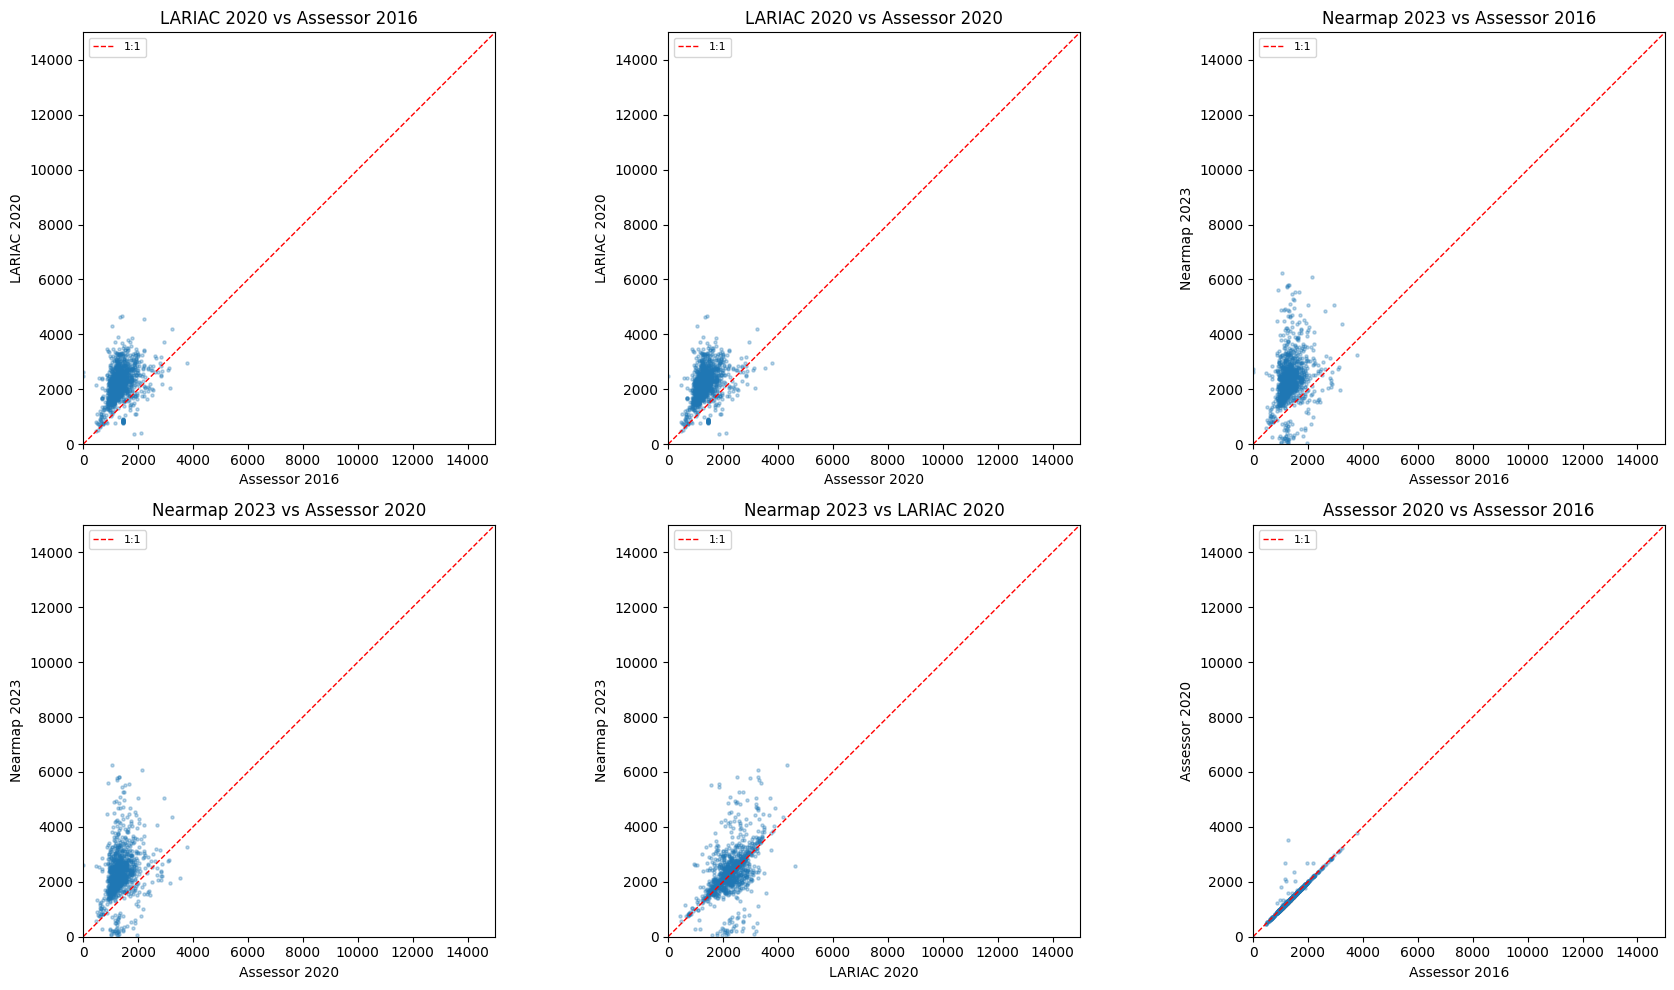

In [172]:
'''--- SCATTER PLOTS: pairwise area comparisons ---'''
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

pairs = [
    ('assessor_area_2016', 'lariac_area_2020',  'Assessor 2016', 'LARIAC 2020'),
    ('assessor_area_2020', 'lariac_area_2020',  'Assessor 2020', 'LARIAC 2020'),
    ('assessor_area_2016', 'nearmap_geomarea_2023', 'Assessor 2016', 'Nearmap 2023'),
    ('assessor_area_2020', 'nearmap_geomarea_2023', 'Assessor 2020', 'Nearmap 2023'),
    ('lariac_area_2020',   'nearmap_geomarea_2023', 'LARIAC 2020',   'Nearmap 2023'),
    ('assessor_area_2016', 'assessor_area_2020','Assessor 2016', 'Assessor 2020'),
]

for ax, (xcol, ycol, xlab, ylab) in zip(axes.flat, pairs):
    ax.scatter(df[xcol], df[ycol], alpha=0.3, s=5)
    ax.plot([0, 15000], [0, 15000], 'r--', lw=1, label='1:1')
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    ax.set_title(f'{ylab} vs {xlab}')
    ax.set_aspect('equal')
    ax.set_xlim(0, 15000)
    ax.set_ylim(0, 15000)
    ax.legend(loc='upper left', fontsize=8)

plt.tight_layout()
plt.show()

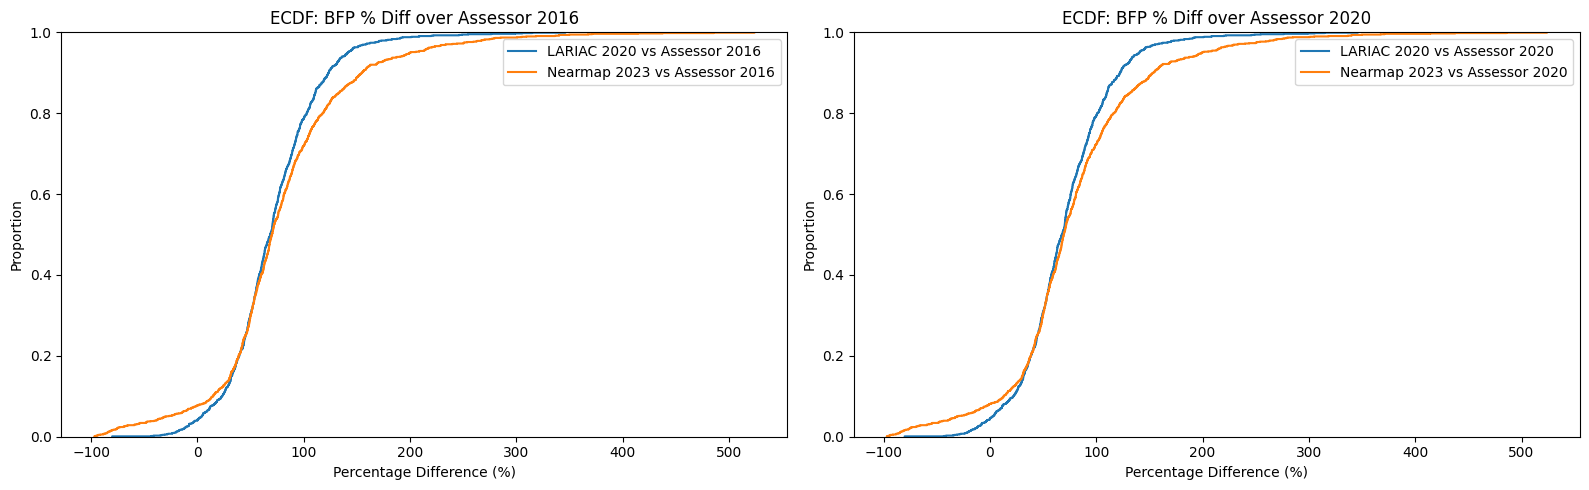

In [173]:
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# ECDF of pct diff vs Assessor 2016
ax = axes[0]
sns.ecdfplot(dfc['pct_diff_lar20_asr16'], label='LARIAC 2020 vs Assessor 2016', ax=ax)
sns.ecdfplot(dfc['pct_diff_nm23_asr16'],  label='Nearmap 2023 vs Assessor 2016', ax=ax)
ax.set_xlabel('Percentage Difference (%)')
ax.set_title('ECDF: BFP % Diff over Assessor 2016')
ax.legend()

# ECDF of pct diff vs Assessor 2020
ax = axes[1]
sns.ecdfplot(dfc['pct_diff_lar20_asr20'], label='LARIAC 2020 vs Assessor 2020', ax=ax)
sns.ecdfplot(dfc['pct_diff_nm23_asr20'],  label='Nearmap 2023 vs Assessor 2020', ax=ax)
ax.set_xlabel('Percentage Difference (%)')
ax.set_title('ECDF: BFP % Diff over Assessor 2020')
ax.legend()

plt.tight_layout()
plt.show()

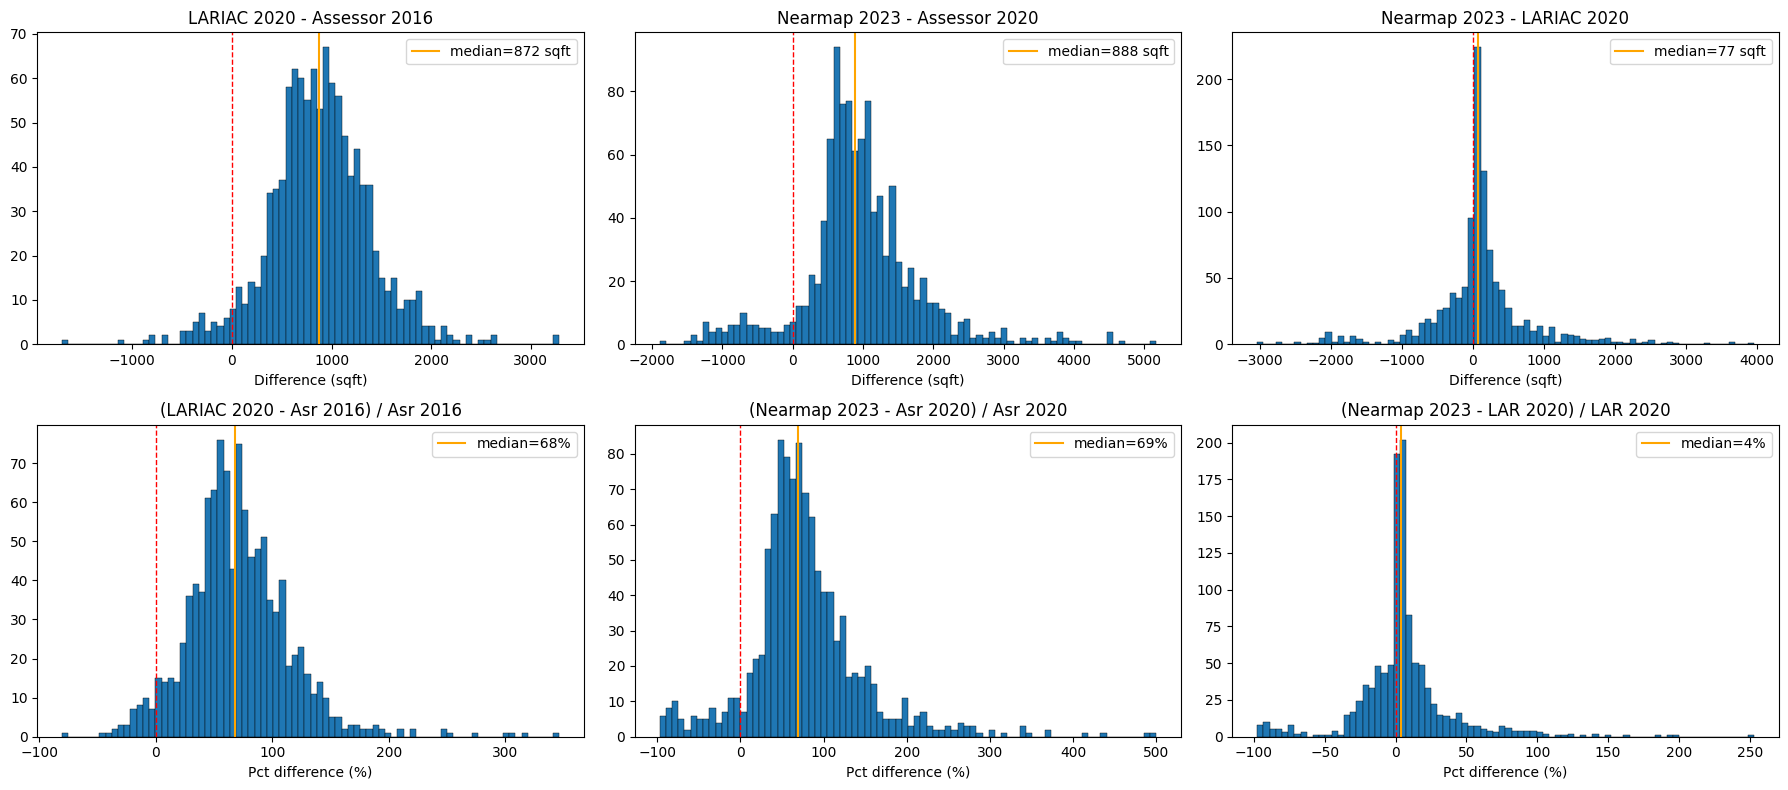

In [174]:
'''--- HISTOGRAMS: difference & pct difference distributions ---'''
fig, axes = plt.subplots(2, 3, figsize=(18, 8))

# Row 1: absolute differences
diff_pairs = [
    ('diff_lar20_asr16', 'LARIAC 2020 - Assessor 2016'),
    ('diff_nm23_asr20',  'Nearmap 2023 - Assessor 2020'),
    ('diff_nm23_lar20',  'Nearmap 2023 - LARIAC 2020'),
]
for ax, (col, title) in zip(axes[0], diff_pairs):
    vals = dfc[col].clip(-5000, 10000)
    ax.hist(vals, bins=80, edgecolor='black', linewidth=0.3)
    ax.axvline(0, color='red', linestyle='--', lw=1)
    ax.axvline(dfc[col].median(), color='orange', lw=1.5, 
               label=f'median={dfc[col].median():.0f} sqft')
    ax.set_title(title)
    ax.set_xlabel('Difference (sqft)')
    ax.legend()

# Row 2: percentage differences
pct_pairs = [
    ('pct_diff_lar20_asr16', '(LARIAC 2020 - Asr 2016) / Asr 2016'),
    ('pct_diff_nm23_asr20',  '(Nearmap 2023 - Asr 2020) / Asr 2020'),
    ('pct_diff_nm23_lar20',  '(Nearmap 2023 - LAR 2020) / LAR 2020'),
]
for ax, (col, title) in zip(axes[1], pct_pairs):
    vals = dfc[col].clip(-200, 500)
    ax.hist(vals, bins=80, edgecolor='black', linewidth=0.3)
    ax.axvline(0, color='red', linestyle='--', lw=1)
    ax.axvline(dfc[col].median(), color='orange', lw=1.5,
               label=f'median={dfc[col].median():.0f}%')
    ax.set_title(title)
    ax.set_xlabel('Pct difference (%)')
    ax.legend()

plt.tight_layout()
plt.show()

In [175]:
'''--- FLAG PARCELS: BFP exceeds same-year assessor record ---
Using same-year comparisons to remove temporal mismatch:
  LARIAC 2020 vs Assessor 2020
  Nearmap 2023 vs Assessor 2020 (closest available)
'''
PCT_THRESHOLD = 50  # percent

dfc['flag_lar20'] = dfc['pct_diff_lar20_asr20'] > PCT_THRESHOLD
dfc['flag_nm23']  = dfc['pct_diff_nm23_asr20']  > PCT_THRESHOLD
dfc['flag_both']  = dfc['flag_lar20'] & dfc['flag_nm23']

print(f"Parcels where BFP > {PCT_THRESHOLD}% more than Assessor 2020:")
print(f"  LARIAC 2020:  {dfc['flag_lar20'].sum()} ({dfc['flag_lar20'].mean()*100:.1f}%)")
print(f"  Nearmap 2023: {dfc['flag_nm23'].sum()} ({dfc['flag_nm23'].mean()*100:.1f}%)")
print(f"  Both agree:   {dfc['flag_both'].sum()} ({dfc['flag_both'].mean()*100:.1f}%)")

# growth between BFP sources
GROWTH_PCT = 20
dfc['flag_growth'] = dfc['pct_diff_nm23_lar20'] > GROWTH_PCT
print(f"\nParcels where Nearmap 2023 > {GROWTH_PCT}% more than LARIAC 2020:")
print(f"  {dfc['flag_growth'].sum()} ({dfc['flag_growth'].mean()*100:.1f}%)")

# assessor record change
dfc['flag_asr_change'] = dfc['pct_diff_asr20_asr16'].abs() > 10
print(f"\nParcels where Assessor changed >10% (2016 to 2020):")
print(f"  {dfc['flag_asr_change'].sum()} ({dfc['flag_asr_change'].mean()*100:.1f}%)")

Parcels where BFP > 50% more than Assessor 2020:
  LARIAC 2020:  751 (69.2%)
  Nearmap 2023: 757 (69.7%)
  Both agree:   629 (57.9%)

Parcels where Nearmap 2023 > 20% more than LARIAC 2020:
  205 (18.9%)

Parcels where Assessor changed >10% (2016 to 2020):
  12 (1.1%)


In [176]:
dfc.sort_values(by='pct_diff_nm23_asr16', ascending=False).tail(2)

,assessor_size,lariac_area_2020,nearmap_area_2023,nearmap_geomarea_2023,assessor_area_2016,assessor_area_2020,lariac_geom_2020,nearmap_geom_2023,landbase_geom_2016,diff_lar20_asr16,...,pct_diff_nm23_asr20,pct_diff_nm23g_asr16,pct_diff_nm23g_asr20,pct_diff_nm23_lar20,pct_diff_asr20_asr16,flag_lar20,flag_nm23,flag_both,flag_growth,flag_asr_change
AIN,,,,,,,,,,,,,,,,,,,,,
5018022006,1.0,1960.170848,46.0,47.370729,1280.0,1280.0,"MULTIPOLYGON (((6474938.17 1821661.59, 6474928...","POLYGON ((6474924.895 1821665.3, 6474920.017 1...","POLYGON ((6474938.808 1821744.458, 6474938.906...",680.170848,...,-96.406250,-96.299162,-96.299162,-97.653266,0.0,True,False,False,False,False
5018034033,1.0,1780.256960,57.0,56.430093,1950.0,1950.0,"POLYGON ((6476278.25 1823793.69, 6476278.312 1...","POLYGON ((6476269.751 1823746.888, 6476270.185...","POLYGON ((6476284.857 1823707.563, 6476244.851...",-169.743040,...,-97.076923,-97.106149,-97.106149,-96.798215,0.0,False,False,False,False,False


<Axes: >

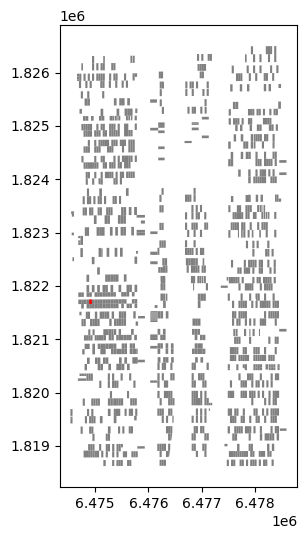

In [171]:
f, ax = plt.subplots(figsize=(8, 6))
Z = df.loc[[5018022006]]
df.plot( ax=ax, color = 'grey')

Z.plot(color = 'red', ax = ax)

# Z.set_geometry('lariac_geom_2020').plot(ax=ax, color='lightgray', edgecolor='black')
# Z.set_geometry('nearmap_geom_2023').plot(ax=ax, color='lightblue', edgecolor='black')